# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [113]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


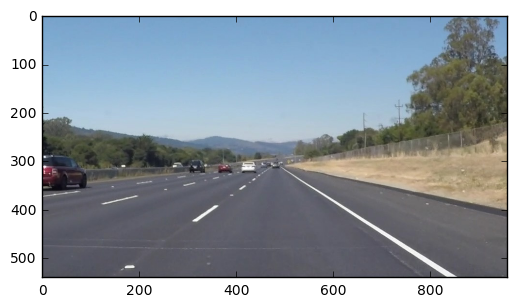

In [114]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image);  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [115]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    #return np.dstack((img[:,:,2],img[:,:,2],img[:,:,2]))
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def draw_extrapolated_lines(image, lines, color=[0, 255, 0], thickness=2):
    """
    Draw lines that run through top and bottom edges of image.
    """
    for line in lines:
        for x1, y1, x2, y2 in line:
            try:
                m = (y2-y1)/(x2-x1)
                b = y1 - m * x1
                height = image.shape[0]

                def x(y):
                    return int((y - b) / m)

                cv2.line(image, (x(0), 0), (x(height), height), color, thickness)
            except:
                pass

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return [line_img, lines]

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [116]:
import os
test_images = os.listdir("test_images/")

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [117]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [126]:
class LineMemory:
    """ This class implements a simple FIFO to contain multiple frames worth of 
        hough lines and reduce the weight of any one frame to the overall result
    """
    def __init__(self):
        self.pages = []
        self.MAX_PAGES = 10
        
    def addPage(self, lines):
        if len(self.pages) > self.MAX_PAGES:
            self.pages.pop(0)
        self.pages.append(lines)
        
    def clear(self):
        self.pages = []
        
    def getLines(self):
        return np.concatenate(self.pages, axis=0)
        
line_memory = LineMemory()

def process_image(image, debug=False, 
                  blur=5, 
                  canny_low=100, canny_high=150,
                  rho=4, theta=1*np.pi/180, threshold=10, min_line_len=15, max_line_gap=1,
                  line_memory=line_memory, use_memory=True, show_hough_lines=False):
    # good enough = 10,15
    """ This method implements a pipeline to process a single image of a road 
        and attempt to detect line lanes in the image.
        In order to smooth out "noise" in the image, an optional memory is implemented
        which adds together the line results of multiple frames to acheive a sort of
        moving average. 
        
        args:
            image - the image to be processed
            debug - whether to ouput log messages
            blur - the gaussian blur kernel size to use
            canny_low - the low threshold for canny edge detection
            canny_high - the high threshold for canny edge detection
            rho - distance resolution in pixels of the Hough grid
            theta - angular resolution in radians of the Hough grid
            threshold - minimum number of votes (intersections in Hough grid cell)
            min_line_len - minimum number of pixels making up a line
            max_line_gap - maximum gap in pixels between connectable line segments   
            line_memory - LineMemory object to use for storing multiple frames
            use_memory - whether to use the line memory to smooth out results
            show_hough_lines - whether to render hough lines on the image
    """
    def log(text, *args):
        if debug:
            print(text % args)

    # convert to grayscale
    # using V component of HSV to get better results with yellow lines in challenge problem
    # gray = grayscale(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    gray = np.dstack((gray[:,:,2],gray[:,:,2],gray[:,:,2]))

    # get width and height of image
    width = gray.shape[1]
    height = gray.shape[0]
    log("width=%d height=%d", width, height)

    # perform gaussian blur
    gray = gaussian_blur(gray, blur)

    # perform canny edge detection
    edges = canny(gray, canny_low, canny_high)

    # extract ROI
    apex = [width*.5, height*.5]
    left = [width*.1, height]
    right = [width*.9, height]
    vertices = np.array([[apex, left, right]], dtype=np.int32)
    edges = region_of_interest(edges, vertices)

    # perform hough transform and pick lines
    hough, lines = hough_lines(edges, rho, theta, threshold, min_line_len, max_line_gap)
    log("number of lines=%d", len(lines))

    # if memory is enabled, add line result to memory object and get all lines for
    # the number of pages defined in the memory by MAX_PAGES
    if use_memory:
        line_memory.addPage(lines)
        lines = line_memory.getLines()
    
    # tan (theta) = opp/adj
    angles = np.arctan((lines[:,:,3] - lines[:,:,1])/(lines[:,:,2] - lines[:,:,0]))
    def get_single_line(direction):
        """ Use a 1st-order polynomial fit to x, y coordinates
            of lines matching a filter criteria (for angle).
            This works unless there are a lot of false edges.
        """
        filtered_lines = lines[np.where(direction)]
        x1 = np.append(filtered_lines[:,0],filtered_lines[:,2])
        y1 = np.append(filtered_lines[:,1],filtered_lines[:,3])
        c = np.polyfit(y1,x1,1)
        p = np.poly1d(c)
        line = [int(p(height*.6)),int(height*.6),int(p(height)),int(height)]
        #x = c0 * y + c1 => y = (x-c1)/c0 = 1/c0 * x - c1/c0
        return [180*np.arctan(1/c[0])/np.pi, p(height), height, np.array([[line]])]

    line_img = np.zeros(image.shape, dtype=np.uint8)
    # draw_extrapolated_lines(line_img, lines)
    # draw_lines(line_img, lines)
    min_angle = 30 * np.pi / 180

    try:
        angle, x, y, line = get_single_line(angles > min_angle)
        cv2.putText(line_img, "a=%+.02f x=%.02f y=%.02f" % (angle,x,y), (10,30), cv2.LINE_AA, .8, (255,255,255))
        draw_lines(line_img, line, thickness=10)
    except:
        pass

    try:
        angle, x, y, line = get_single_line(angles < -min_angle)
        cv2.putText(line_img, "a=%+.02f x=%.02f y=%.02f" % (angle,x,y), (10,60), cv2.LINE_AA, .8, (255,255,255))
        draw_lines(line_img, line, thickness=10)
    except:
        pass
    
    if show_hough_lines:
        out_img = np.dstack((edges*0, edges, edges*0)) 
        hough = np.dstack((hough, hough, hough)) 
        out_img =  weighted_img(line_img, out_img, α=0.8)
        #return out_img
        out_img = weighted_img(out_img, hough, α=0.8)
        return weighted_img(out_img, gray, α=0.8)
    else:
        return weighted_img(line_img, image, α=0.8)

width=960 height=540
number of lines=15


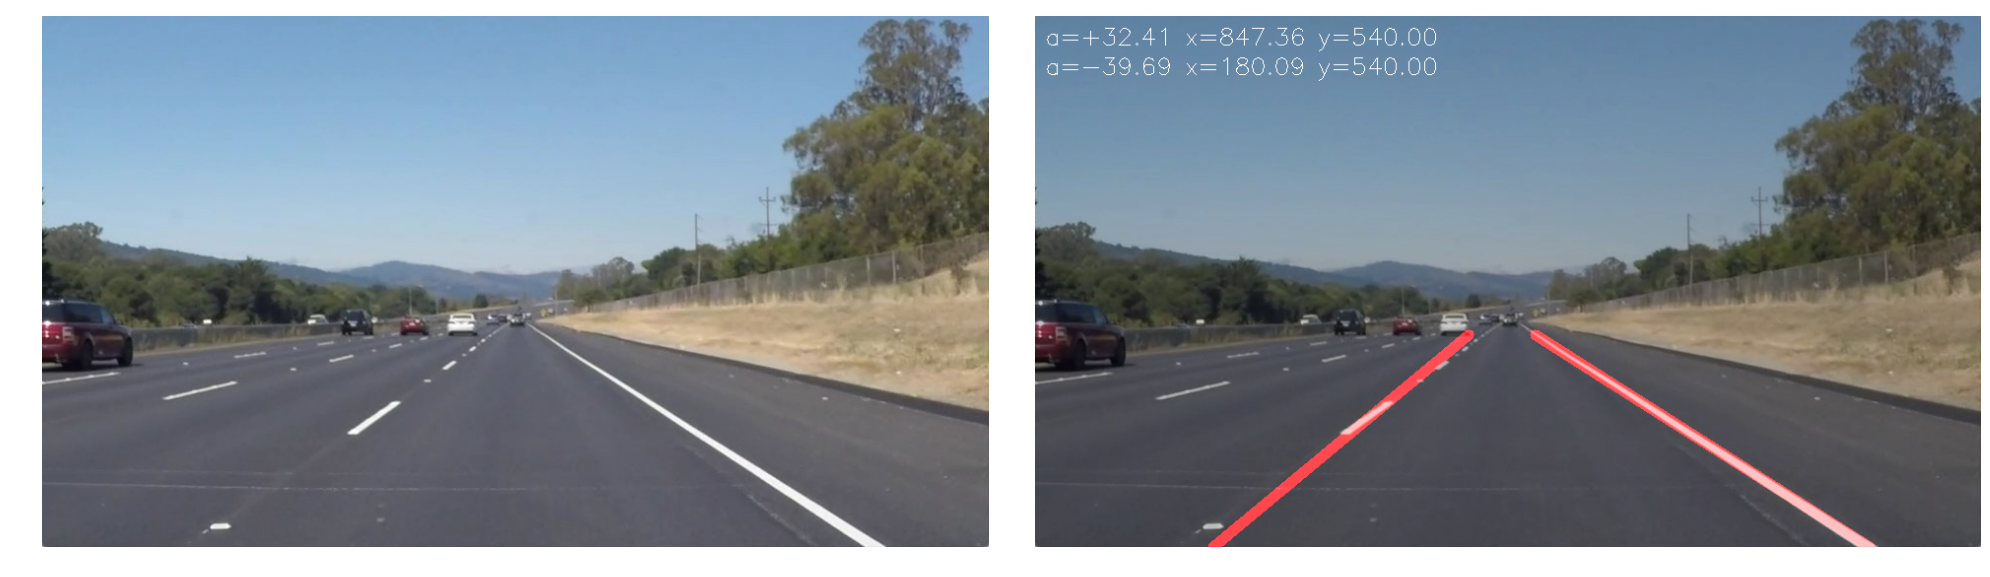

width=960 height=540
number of lines=18


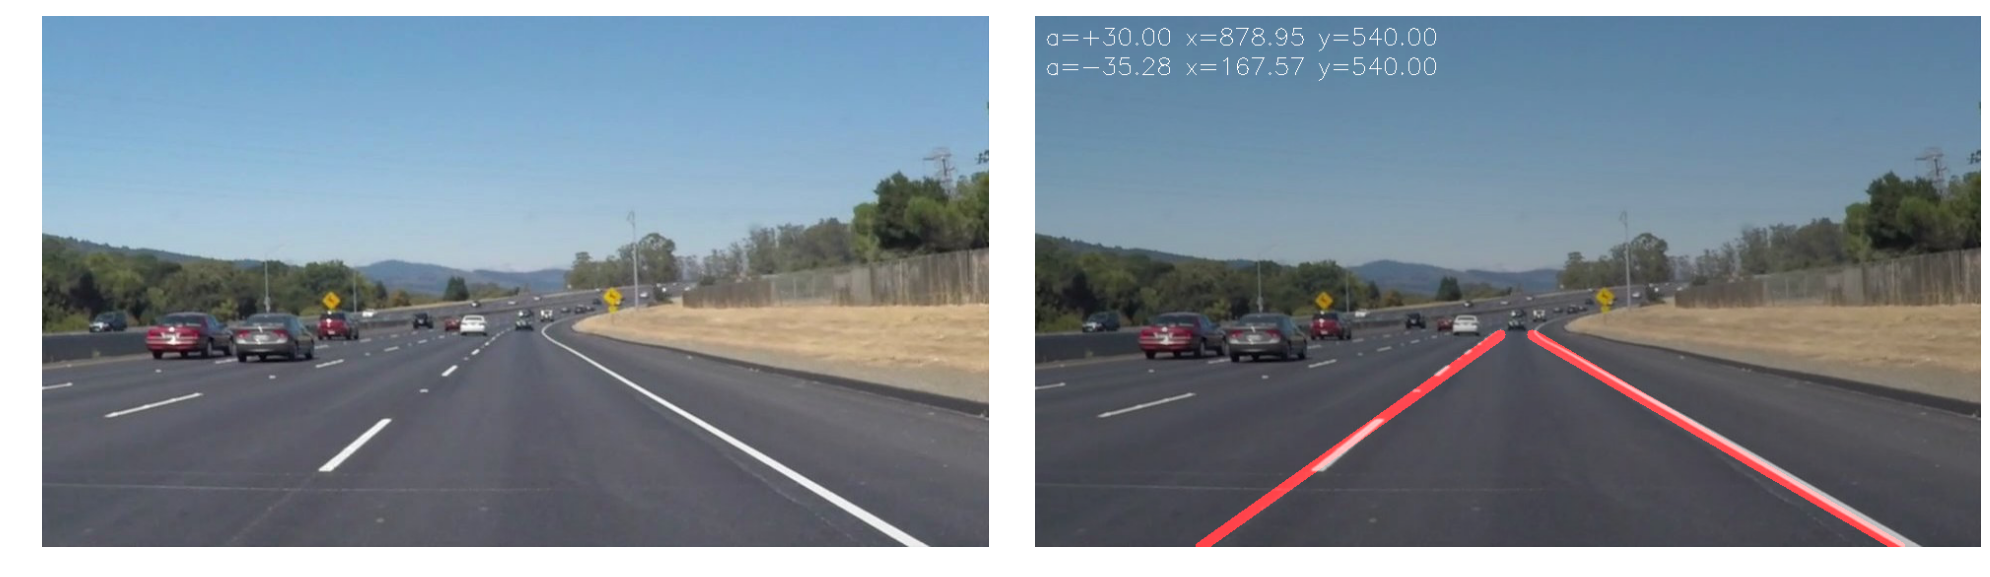

width=960 height=540
number of lines=12


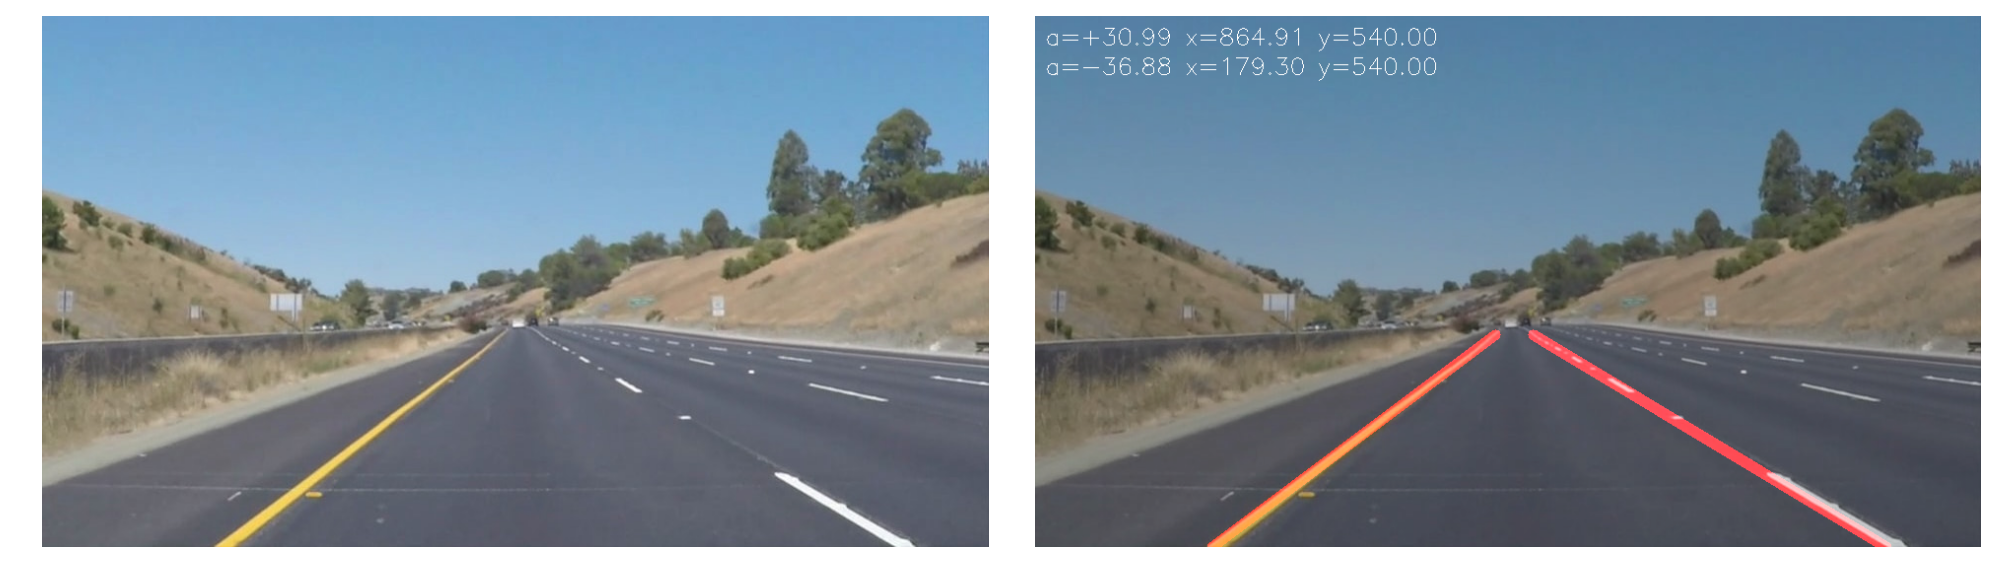

width=960 height=540
number of lines=16


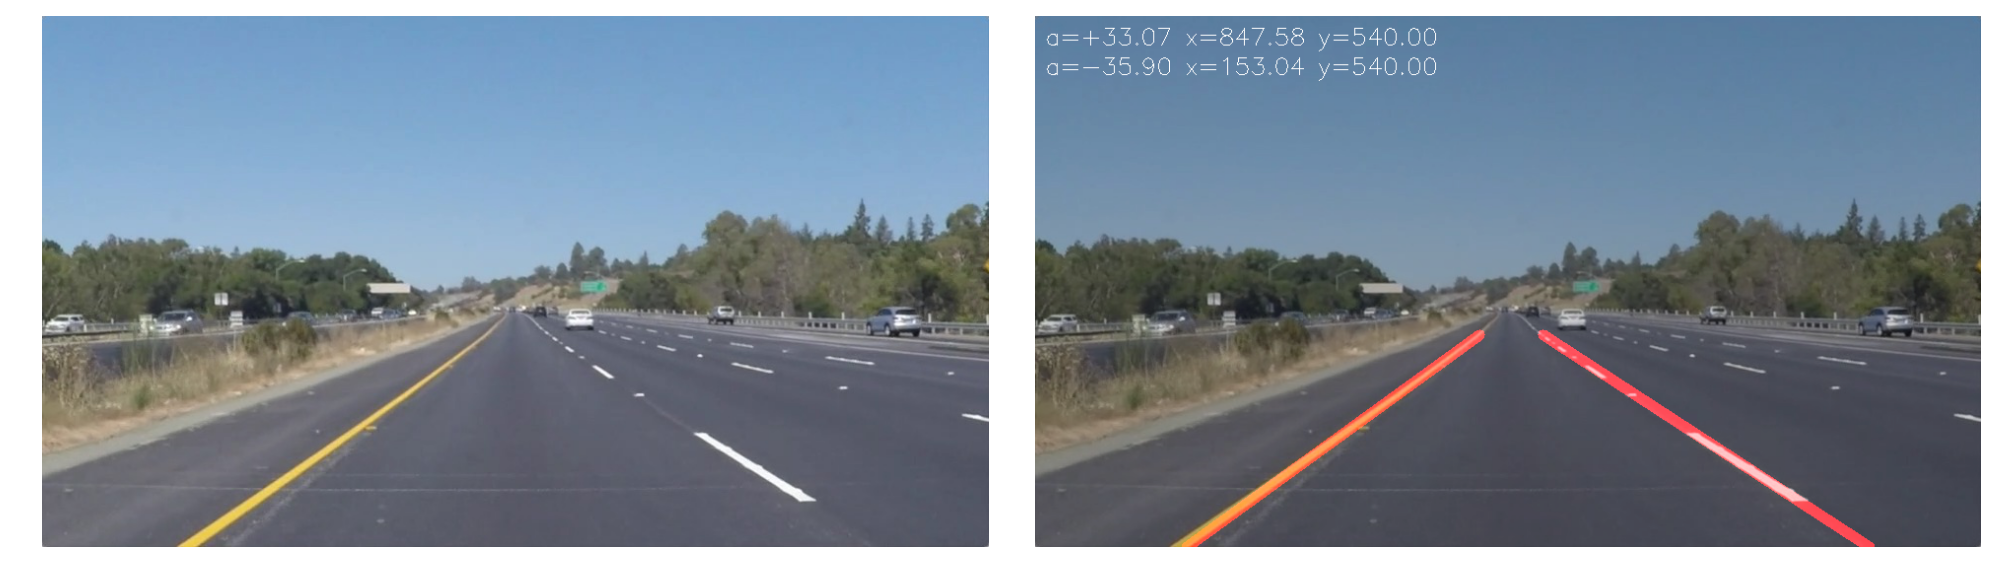

width=960 height=540
number of lines=15


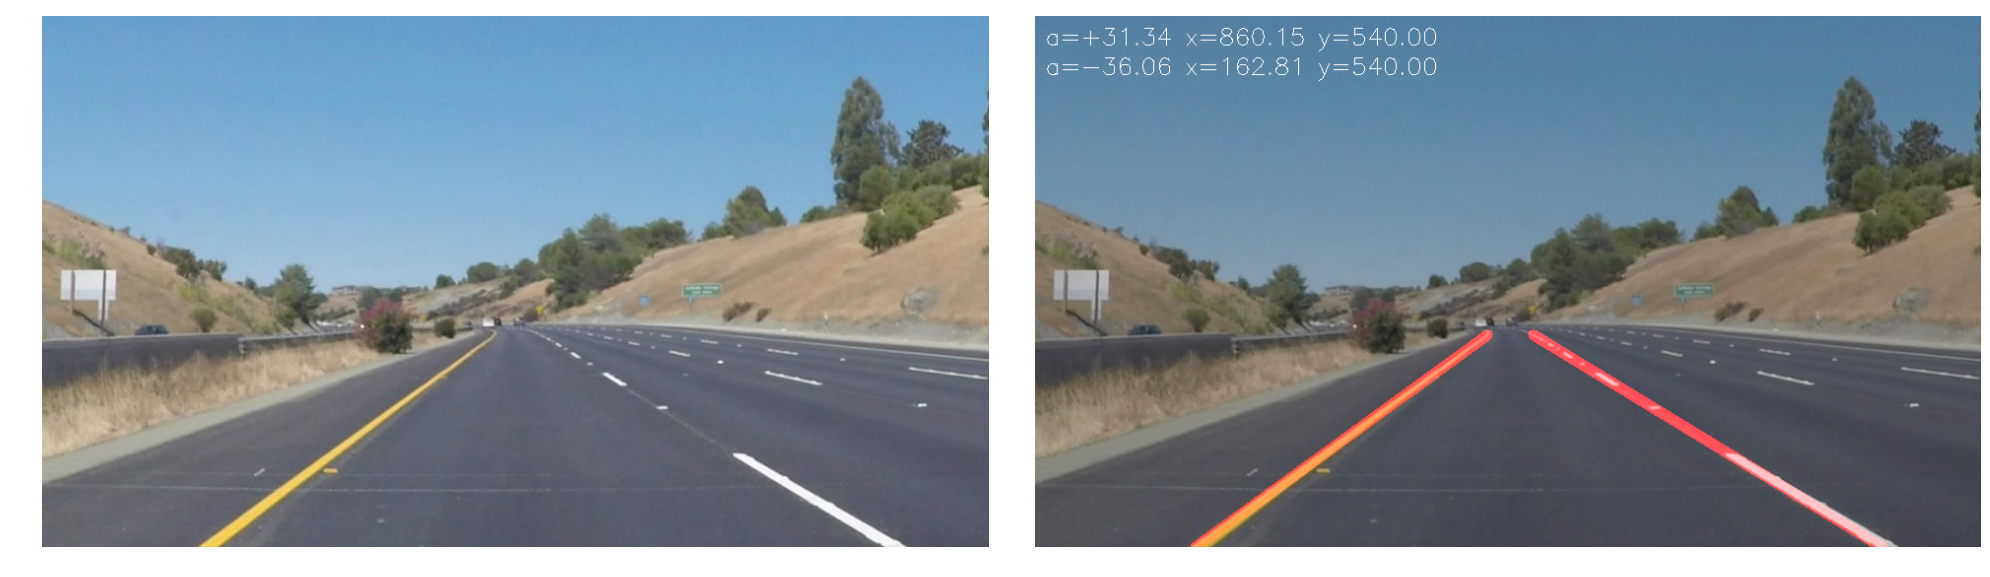

width=960 height=540
number of lines=14


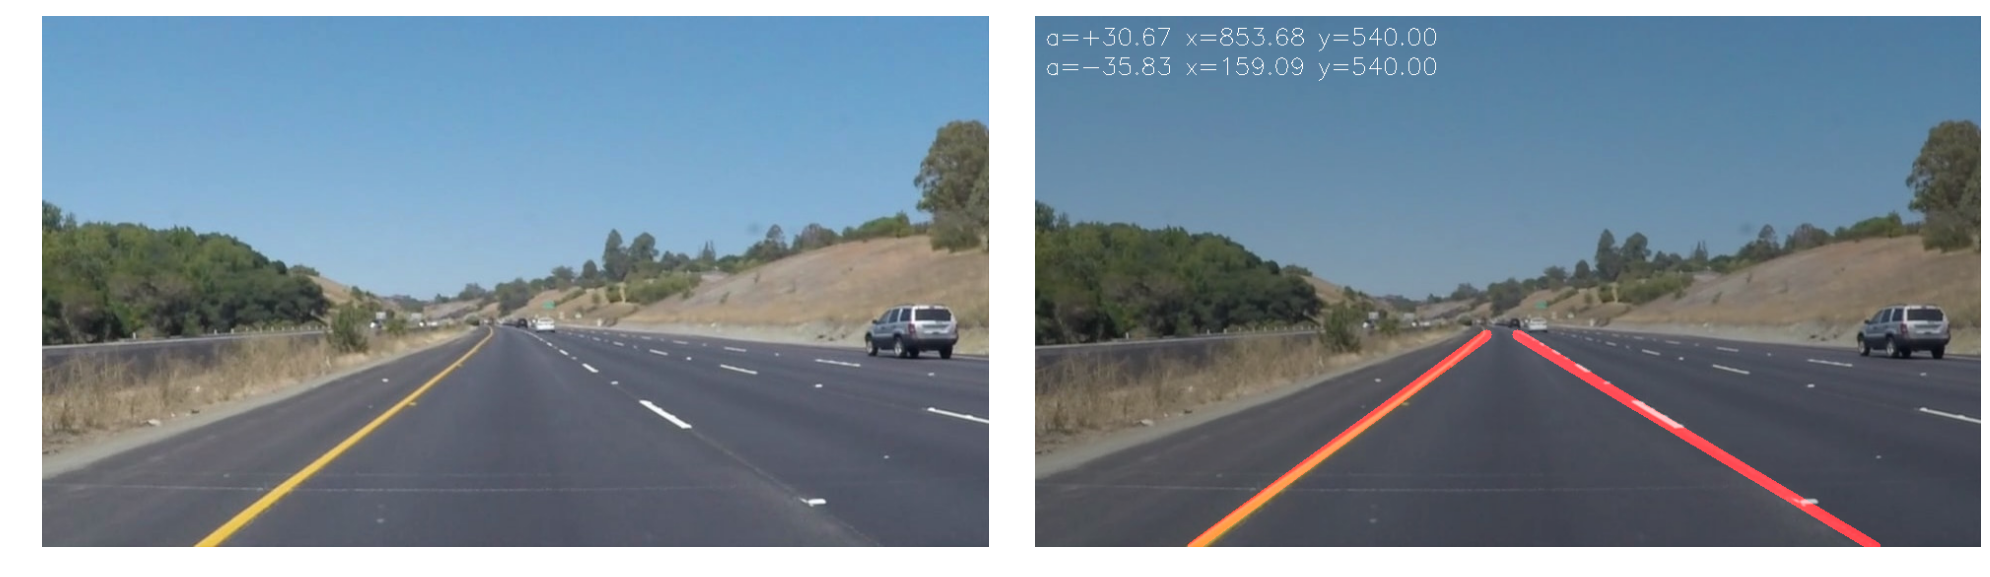

In [131]:
num_images = len(test_images)

for index, image_path in enumerate(test_images):
    image = mpimg.imread('test_images/' + image_path)
    image_processed = process_image(image, debug=True, use_memory=False)
    fig, axes = plt.subplots(1,2,figsize=(20,15))
    axes[0].axis('off')
    axes[0].imshow(image)
    axes[1].axis('off')
    axes[1].imshow(image_processed, cmap='gray');
    plt.tight_layout()
    plt.show()

Let's try the one with the solid white lane on the right first ...

In [127]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:11<00:00, 15.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1min 20s, sys: 2.43 s, total: 1min 22s
Wall time: 12.5 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [128]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [132]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
line_memory.clear()
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:36<00:00, 18.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 3min 51s, sys: 7.72 s, total: 3min 59s
Wall time: 36.9 s


In [133]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

----
I observed that when converting the challenge problem video colorspace to grayscale, the contrast between the yellow lines and gray road was very low in some frames. By using the HSV colorspace instead, and extracting only the Value component to use in subsequent edge detection, I observed better results.

With the dotted lines in the roadway there exists certain frames where the closest line to the camera is a gap, such that line detection does not find any lines or very small lines for the dotted roadway line. If I reduce the min_line_len or threshold parameters of the HoughP algorithm, I can capture the smaller line segments which are farther away from the camera, but I also get other unwanted lines which skew the average/median results for the line angle and position. To mitigate this, I add up the detected lines from multiple subsequent frames and then perform a polynomial fit to the data. This acheives a better result since there should be more points within the road lines than noise over multiple frames. I found that fitting over 10 frames or less worth of data acheived a good result, more than this and the "delay" in updates to line changes is noticeable. Of course this method would be affected by the frame rate of the camera and vehicle velocity, so there probably would need to be a more sophisticated approach in a real world application.

The algorithm could probably be improved further by optimizing the hough parameters through an iterative approach over many images. Curved roadway could be detected by increasing the polynomial degree in the polynomial fitting step and plotting a curve instead of a straight line. For this to work, the "memory" of previous images would probably need to be changed to a memory of the coefficients of previous images which could be updated through a feedback loop. 

## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [129]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
line_memory.clear()
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:24<00:00, 10.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 2min 36s, sys: 5.08 s, total: 2min 41s
Wall time: 25.3 s


In [130]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))